In [1]:
import json
import ROOT
from analysis_framework import Dataset, Analysis
import os

OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x73acce0


In [2]:
# urgh the OOs cannot handle this!!!!
# ROOT.EnableImplicitMT(12)

In [3]:
# CLD
# x_angle = 0.030 # rad
# ILD
x_angle = 0.014 # rad
# use same masses as in whizard!
mW = 80.419
mZ = 91.1882

In [4]:

ROOT.gSystem.Load("OO/diehl/libObservable.so")
ROOT.gInterpreter.Declare("#include \"OO/diehl/OOTools.h\"")
ROOT.OOTools.init(250, mW, mZ)

In [5]:
# dataset = Dataset.from_json("data/datasets/snapshots/full.json")
# dataset = Dataset.from_json("checked-test.json")
# dataset = Dataset.from_json("checked-full.json")
dataset = Dataset.from_json("checked-signal-only-full-local.json")

In [6]:
analysis = Analysis(dataset)
# analysis.init_parameters([
#     ("Energy", "float", "-1.0"),
# ])
ROOT.gInterpreter.Declare("#include <podio/GenericParameters.h>")
analysis.Define("params_Energy", "Parameters.get<float>(\"Energy\").value_or(-1.0)")

In [7]:
analysis.set_categories({
    "4f_sw_sl_eLpL": {"pattern": "4f_sw_sl_eLpL", "cut": None},
    "4f_sw_sl_eRpL": {"pattern": "4f_sw_sl_eRpL", "cut": None},
    "4f_sw_sl_eRpR": {"pattern": "4f_sw_sl_eRpR", "cut": None},
    "4f_sw_sl_eLpR": {"pattern": "4f_sw_sl_eLpR", "cut": None},
})
# check if we missed any processes
print(analysis.is_complete_categorisation())

True


In [8]:
print(json.dumps(analysis._categories, indent=2))

{
  "4f_sw_sl_eLpL": [
    "4f_sw_sl_eLpL_signal"
  ],
  "4f_sw_sl_eRpL": [
    "4f_sw_sl_eRpL_signal"
  ],
  "4f_sw_sl_eRpR": [
    "4f_sw_sl_eRpR_signal"
  ],
  "4f_sw_sl_eLpR": [
    "4f_sw_sl_eLpR_signal"
  ]
}


In [9]:
# needed for the .size() calls... alternative would probably be to .Alias the @size columns
ROOT.gInterpreter.Declare("#include <podio/ObjectID.h>")
ROOT.gInterpreter.Declare("#include <edm4hep/ReconstructedParticleData.h>")
make_lvec = lambda coll_name: f"ROOT::VecOps::Construct<ROOT::Math::PxPyPzEVector>({coll_name}.momentum.x, {coll_name}.momentum.y, {coll_name}.momentum.z, {coll_name}.energy)"
analysis.Define("R2jet_lvecs", make_lvec("Refined2Jets"))
analysis.Define("n_neutral_PFOs", "Sum(abs(PandoraPFOs.charge) == 0.)")
analysis.Define("charged_fraction", "n_charged_PFOs / static_cast<double>(n_charged_PFOs + n_neutral_PFOs)")

In [10]:
# filter on missing energy > 0

In [11]:
# TODO: define truth objects! (Not super trivial for the quarks without truejet but should be doable)

In [12]:
# select isolated lepton and the two jets and build Ws and neutrino
analysis.Define("iso_lep_idx", "IsolatedElectrons_objIdx.index[0]")
analysis.Define("iso_lep_charge", "PandoraPFOs.charge[iso_lep_idx]")
# TODO: figure out: are isolated electrons also always Pandora electrons? :( (taking a look into the IsolatedLeptonTagging shows that this is not required!)
analysis.Define("iso_lep_lvec", "ROOT::Math::PxPyPzEVector(PandoraPFOs.momentum.x[iso_lep_idx], PandoraPFOs.momentum.y[iso_lep_idx], PandoraPFOs.momentum.z[iso_lep_idx], PandoraPFOs.energy[iso_lep_idx])")
analysis.Define("jet1_lvec", "R2jet_lvecs[0]")
analysis.Define("jet2_lvec", "R2jet_lvecs[1]")
analysis.Define("sqrt_s_E", "params_Energy")
# XXX: ignoring the electron mass here
analysis.Define("sqrt_s_lvec", f"ROOT::Math::PxPyPzEVector(sqrt_s_E * sin({x_angle}/2.), 0, 0, sqrt_s_E)")
analysis.Define("hadronic_W_lvec", "jet1_lvec + jet2_lvec")
# TODO: overlay contamination etc are still in this...
analysis.Define("leptonic_W_lvec", "sqrt_s_lvec - hadronic_W_lvec")
analysis.Define("nu_lvec", "leptonic_W_lvec - iso_lep_lvec")

In [13]:
# now we would want to remove the crossing angle
#small experiment using an actual dd4hep crossing angle boosted e+e- pair:
# e_lvec = ROOT.Math.PxPyPzMVector(+8.750143e-01, 0., +1.250000e+02, +5.109968e-04)
# p_lvec = ROOT.Math.PxPyPzMVector(+8.750143e-01, 0., -1.250000e+02, +5.109968e-04)
# s_lvec = e_lvec + p_lvec
# print(s_lvec)
# beta = s_lvec.BoostToCM()
# print(beta.x(), beta.y(), beta.z())
# boost = ROOT.Math.BoostX(beta.x())
# print(boost(s_lvec))
# print(boost(e_lvec))
# print(ROOT.Math.sin(0.007))
# boost2 = ROOT.Math.BoostX(-ROOT.Math.sin(0.007))
# print(boost2(s_lvec))
# print(boost2(e_lvec))
ROOT.gInterpreter.Declare(f"ROOT::Math::BoostX unboost_xangle(-std::sin({x_angle/2}));")
lvec_list = ["iso_lep_lvec", "jet1_lvec", "jet2_lvec", "hadronic_W_lvec", "leptonic_W_lvec", "nu_lvec"]
for lvec in lvec_list:
    analysis.Define(f"ub_{lvec}", f"unboost_xangle({lvec})")

In [14]:
# now we want to calculate the angles as in the Hagiwara parametrisation
# XXX: there is this one decision to make, do we use both measured daughter values or just one and flip it? :(
# TODO: is this well defined for the e+nuqq case?
# I need to be a bit careful, there can be some replacements that are only valid in zero-width CC03
# It all depends on the systems of the measurement actually being the rest-frame of the parent i.e. that the decay are back-to-back
# Exactly in this condition ang(W-, e-) == ang(W+, e+) == Theta_W
# In the W- rest-frame f has theta and phi and fbar has -theta and phi, what are these angles actually
# theta ang(f*, z') with f* in a system rotated such that z' direction of W- in the CMS and y' = P_e- x P_W-
# boosted into the rest-frame of the parent of f
# for now we just act as if we are in the double pole case as in Hagiwara and proceed.
# TODO: guaranteed to not get 0 charge?
analysis.Define("Wm_lvec", "iso_lep_charge < 0. ? ub_leptonic_W_lvec : ub_hadronic_W_lvec")
analysis.Define("Wp_lvec", "iso_lep_charge > 0. ? ub_leptonic_W_lvec : ub_hadronic_W_lvec")
# they literally did not put a cheaper cosTheta accessor into Genvectors...
analysis.Define("Wm_cosTheta", "cos(Wm_lvec.Theta())")

# need to distinguish: f == fermion child of W-, fbar == anti-fermion child of W+
# i.e. Wm == W_lep -> f = iso_lep, fbar = not determinable, need to fold quarks
# i.e. Wm == W_had -> fbar = nu, f = not determinable, need to fold quarks
# so I could make the quark stuff into vectors so that the histograms work but I would also have to divide by two
# or I make both histograms, add them and then divide by two

ROOT.gInterpreter.Declare("#include <WWTools.h>")
# let's act like we are in W_lep == Wm case to proceed
analysis.Define("iso_lep_star_lvec", "WWTools::starVectorHagiwara(ub_leptonic_W_lvec, ub_iso_lep_lvec, {0, 0, 1}, Wm_lvec)")
analysis.Define("nu_star_lvec", "WWTools::starVectorHagiwara(ub_leptonic_W_lvec, ub_nu_lvec, {0, 0, 1}, Wm_lvec)")

analysis.Define("jet1_star_lvec", "WWTools::starVectorHagiwara(ub_hadronic_W_lvec, ub_jet1_lvec, {0, 0, 1}, Wm_lvec)")
analysis.Define("jet2_star_lvec", "WWTools::starVectorHagiwara(ub_hadronic_W_lvec, ub_jet2_lvec, {0, 0, 1}, Wm_lvec)")

for lvec in ["iso_lep", "nu", "jet1", "jet2"]:
    analysis.Define(f"{lvec}_co", f"cos({lvec}_star_lvec.Theta())")
    analysis.Define(f"{lvec}_ph", f"{lvec}_star_lvec.Phi()")

In [15]:

analysis.Define("co", "Wm_cosTheta")
# FIXME: OMFG just make this a stupid c++ function there is literally no reason not to!!!! the types are just doubles!!!
make_proba_fold_1 = lambda co11, co12, co2, ph11, ph12, ph2, cpl, order: f"OOTools::proba(co, {co11}, {co2}, {ph11}, {ph2}, {cpl}, false, {order}) + OOTools::proba(co, {co12}, {co2}, {ph12}, {ph2}, {cpl}, false, {order})"
make_proba_fold_2 = lambda co1, co21, co22, ph1, ph21, ph22, cpl, order: f"OOTools::proba(co, {co1}, {co21}, {ph1}, {ph21}, {cpl}, false, {order}) + OOTools::proba(co, {co1}, {co22}, {ph1}, {ph22}, {cpl}, false, {order})"

analysis.Define("S_0",   f"iso_lep_charge < 0. ? {make_proba_fold_2('iso_lep_co', 'jet1_co', 'jet2_co', 'iso_lep_ph', 'jet1_ph', 'jet2_ph', 0, 0)} : {make_proba_fold_1('jet1_co', 'jet2_co','nu_co', 'jet1_ph', 'jet2_ph', 'nu_ph', 0, 0)}")
analysis.Define("S_1_1", f"iso_lep_charge < 0. ? {make_proba_fold_2('iso_lep_co', 'jet1_co', 'jet2_co', 'iso_lep_ph', 'jet1_ph', 'jet2_ph', 0, 1)} : {make_proba_fold_1('jet1_co', 'jet2_co','nu_co', 'jet1_ph', 'jet2_ph', 'nu_ph', 0, 1)}")
analysis.Define("S_1_2", f"iso_lep_charge < 0. ? {make_proba_fold_2('iso_lep_co', 'jet1_co', 'jet2_co', 'iso_lep_ph', 'jet1_ph', 'jet2_ph', 0, 2)} : {make_proba_fold_1('jet1_co', 'jet2_co','nu_co', 'jet1_ph', 'jet2_ph', 'nu_ph', 0, 2)}")
analysis.Define("S_1_3", f"iso_lep_charge < 0. ? {make_proba_fold_2('iso_lep_co', 'jet1_co', 'jet2_co', 'iso_lep_ph', 'jet1_ph', 'jet2_ph', 0, 3)} : {make_proba_fold_1('jet1_co', 'jet2_co','nu_co', 'jet1_ph', 'jet2_ph', 'nu_ph', 0, 3)}")

analysis.Define("O_1", "S_1_1 / S_0")
analysis.Define("O_2", "S_1_2 / S_0")
analysis.Define("O_3", "S_1_3 / S_0")

# for debug
analysis.Define("co1", "iso_lep_charge < 0. ? iso_lep_co : -iso_lep_co")
analysis.Define("ph1", "iso_lep_charge < 0. ? iso_lep_ph : iso_lep_ph + ROOT::Math::Pi()")

In [16]:
analysis.add_filter("iso_lep_charge < 0.", "only Wm")
analysis.add_filter(f"abs((ub_iso_lep_lvec + ub_nu_lvec).M() - {mW}) < 2.5", "W_lep 2.5GeV")

In [17]:

analysis.book_histogram_1D("RecoCatAdvanced", "RecoCatAdvanced", ("", ";RecoCatAdvanced", 8, 0., 8.))
analysis.book_histogram_1D("n_isoelectrons", "n_isoelectrons", ("", ";n_isoelectrons", 5, 0., 5.))
analysis.book_histogram_1D("n_charged_PFOs", "n_charged_PFOs", ("", ";n_charged_PFOs", 50, 0., 50.))
analysis.book_histogram_1D("n_neutral_PFOs", "n_neutral_PFOs", ("", ";n_neutral_PFOs", 50, 0., 50.))
analysis.book_histogram_1D("misspT", "params_WWCategorisation_misspT", ("", ";misspT", 100, 0., 100.))
analysis.book_histogram_1D("PVertex_ndf", "PVertex_ndf", ("", ";PVertex_ndf", 50, 1., 101.))
analysis.book_histogram_1D("missE", "params_WWCategorisation_missE", ("", ";missE", 300, -50., 250.))
analysis.book_histogram_1D("mInv", "params_WWCategorisation_mInv", ("", ";mInv", 100, 40., 140.))
analysis.book_histogram_1D("M_jj", "M_jj", ("", ";M_jj", 100, 32., 132.))
analysis.book_histogram_1D("n_isomuons", "n_isomuons", ("", ";n_isomuons", 5, 0., 5.))
analysis.book_histogram_1D("PVertex_chi2", "PVertex_chi2", ("", ";PVertex_chi2", 75, 0., 150.))
analysis.book_histogram_1D("PVertex_chi2ndf", "PVertex_chi2ndf", ("", ";PVertex_chi2/ndf", 20, 0., 10.))
analysis.book_histogram_1D("charged_fraction", "charged_fraction", ("", ";charged_fraction", 50, 0., 1.))
analysis.book_histogram_1D("O_1", "O_1", ("", ";O_1", 50, -2.5, 2.5))
analysis.book_histogram_1D("O_2", "O_2", ("", ";O_1", 50, -2.5, 2.5))
analysis.book_histogram_1D("O_3", "O_3", ("", ";O_1", 50, -2.5, 2.5))
analysis.book_histogram_1D("S_0", "S_0", ("", ";S_0", 50, -2.5, 2.5))
analysis.book_histogram_1D("co", "co", ("", ";co", 50, -1., 1.))
analysis.book_histogram_1D("co1", "co1", ("", ";co1", 50, -1., 1.))
analysis.book_histogram_1D("ph1", "ph1", ("", ";co1", 50, -3.14159, 3.14159))

In [18]:
analysis.book_reports()

In [19]:
%%time
analysis.run()

CPU times: user 34.6 s, sys: 3.11 s, total: 37.7 s
Wall time: 48.9 s
OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x11efacd0


In [20]:
analysis.print_reports()

       4f_sw_sl_eLpL       4f_sw_sl_eRpL       4f_sw_sl_eRpR       4f_sw_sl_eLpR
        118909 (5e+02)         87929 (2e+02)        117376 (5e+02)      10125353 (1e+04) All
           140 (2e+01)         43911 (1e+02)        117241 (5e+02)       5059069 (8e+03) only Wm
             4 (3e+00)          4553 (4e+01)          3212 (8e+01)        501028 (2e+03) W_lep 2.5GeV
         4e-05          0.05          0.03          0.05 efficiency


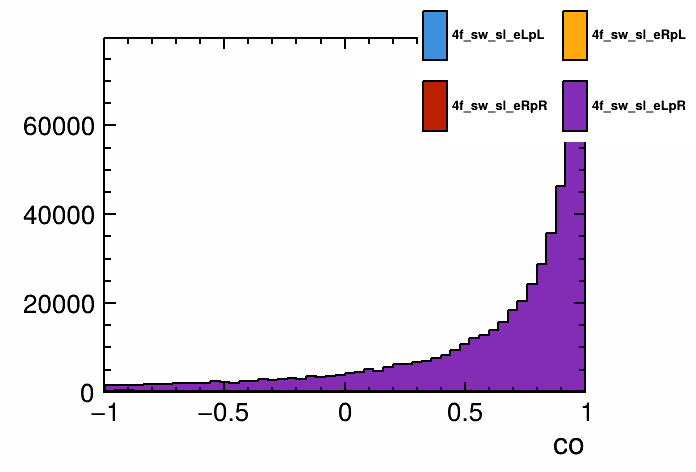

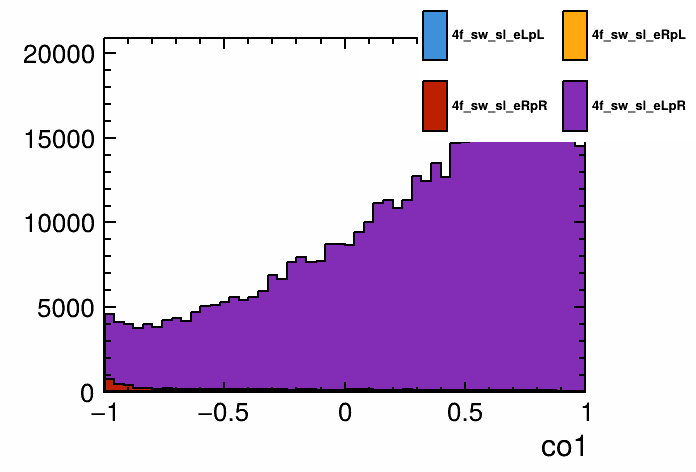

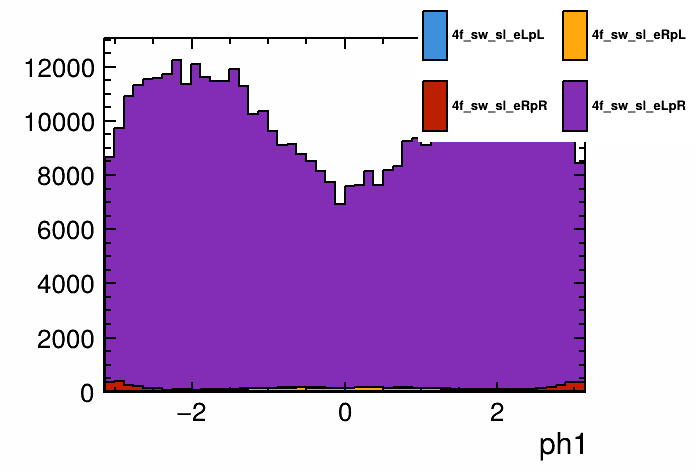

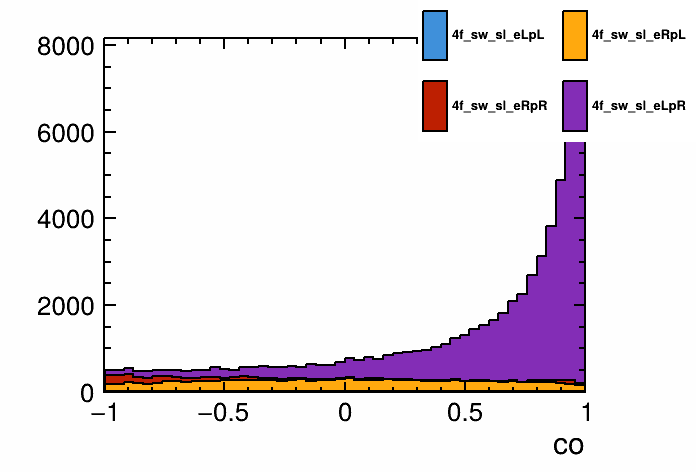

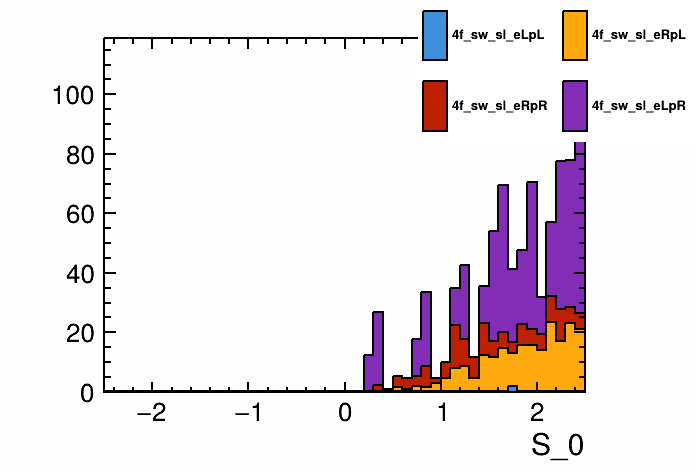

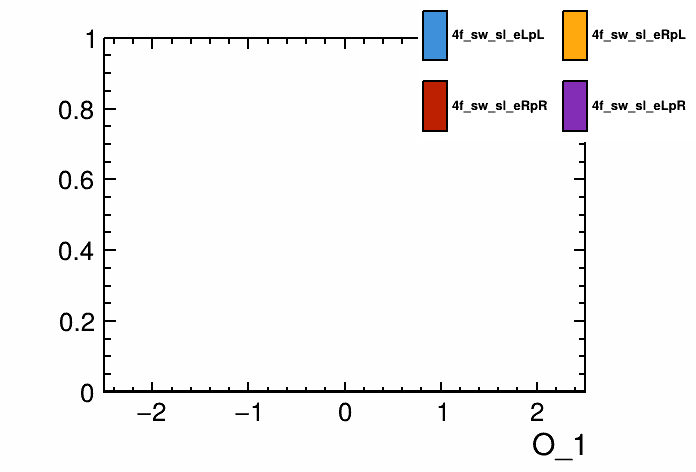

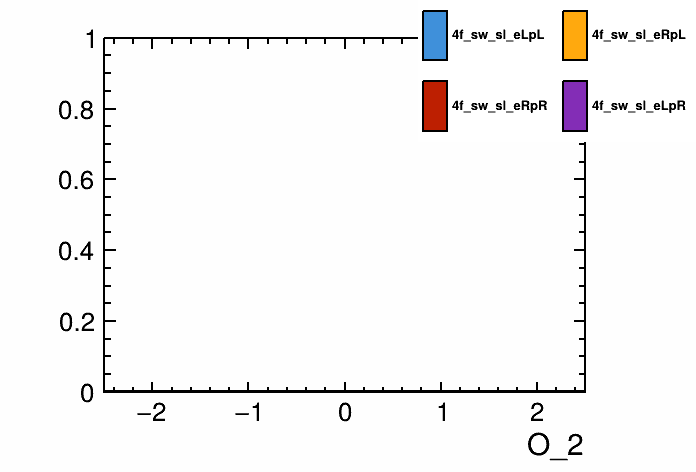

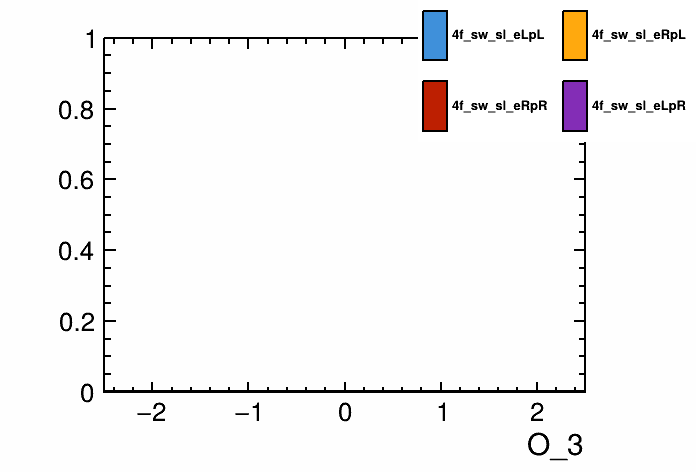

In [21]:
analysis.draw_histogram("co")
analysis.draw_histogram("co1")
analysis.draw_histogram("ph1")
analysis.draw_histogram("co", e_pol=0.8, p_pol=-0.5)
analysis.draw_histogram("S_0")
analysis.draw_histogram("O_1")
analysis.draw_histogram("O_2")
analysis.draw_histogram("O_3")

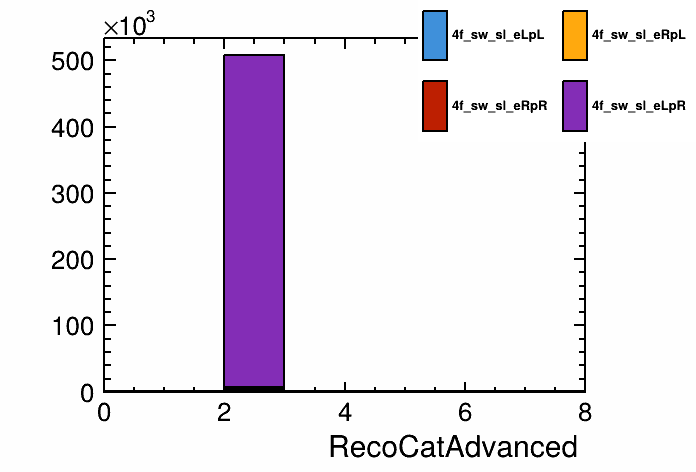

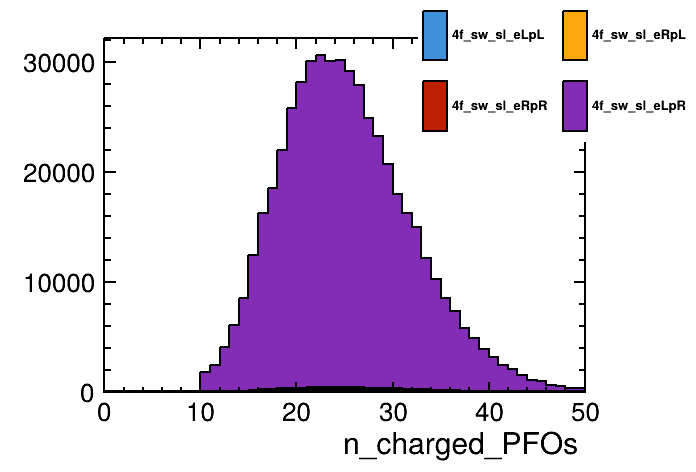

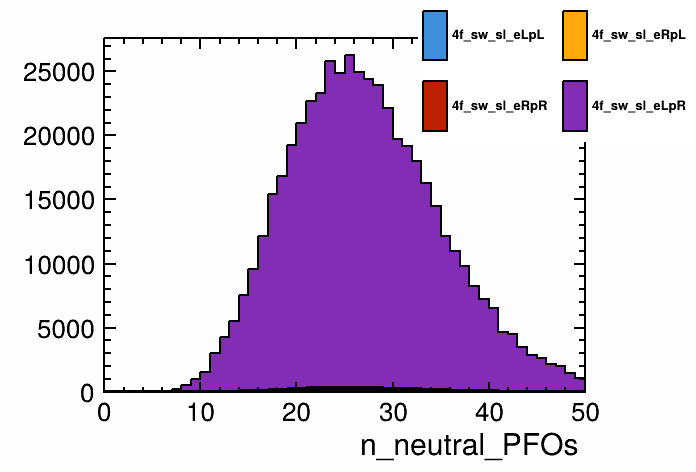

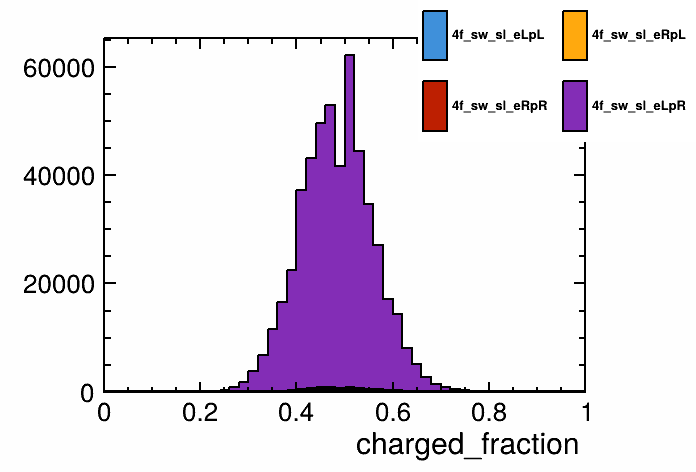

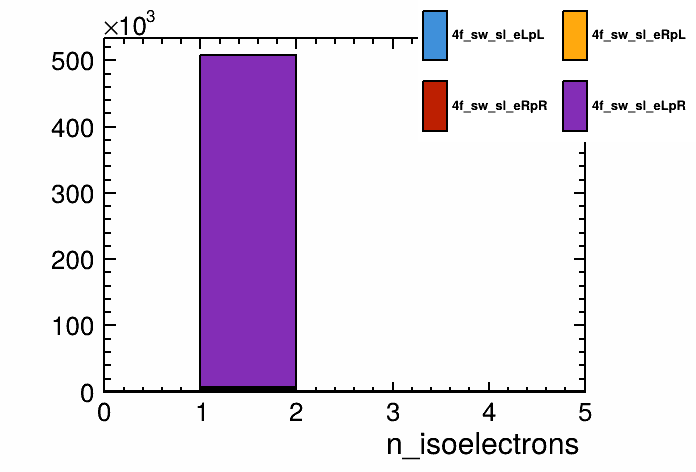

In [22]:
# unfortunately the jsroot plots break all the time, maybe it is just too much for them
# %jsroot on
# 0 - hadronic (both W decay hadronically)
# 1 - invisible semileptonic (one W decays hadronically, but the lepton is not within detector acceptance/detected)
# 2 - semileptonic electron
# 3 - semileptonic muon
# 4 - semileptonic tauon
# 5 - leptonic (both W decay leptonically)
# 6 - other, 7- broken?
analysis.draw_histogram("RecoCatAdvanced")
analysis.draw_histogram("n_charged_PFOs")
analysis.draw_histogram("n_neutral_PFOs")
analysis.draw_histogram("charged_fraction")
analysis.draw_histogram("n_isoelectrons")

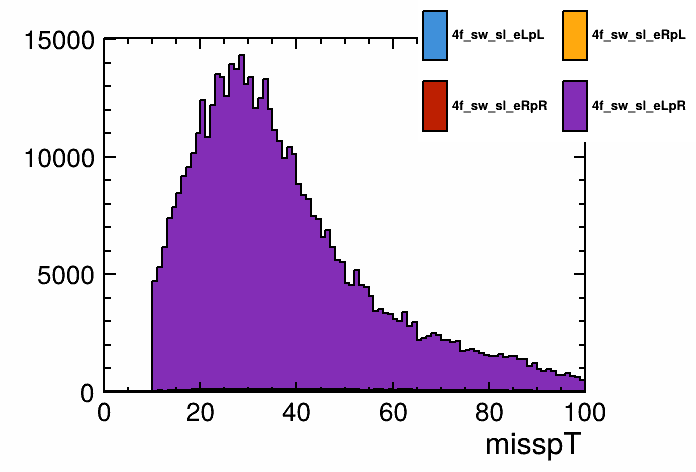

In [23]:
analysis.draw_histogram("misspT")

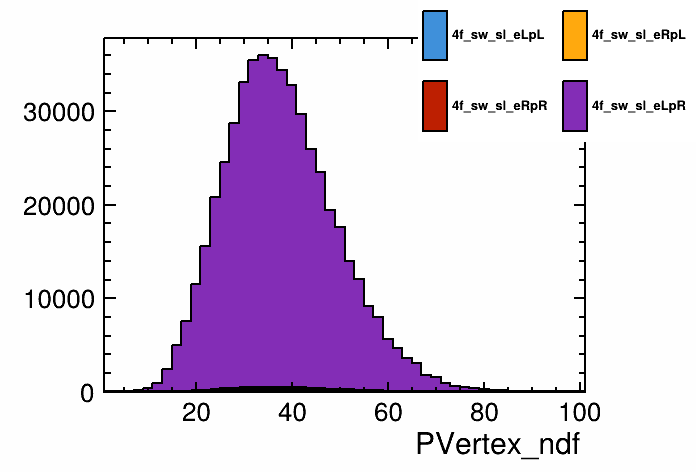

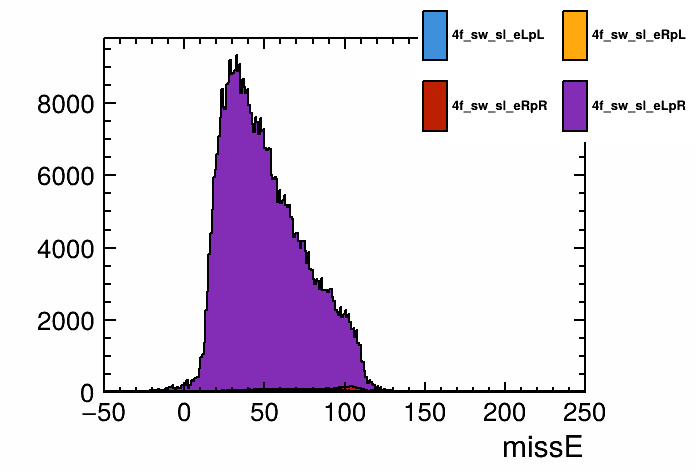

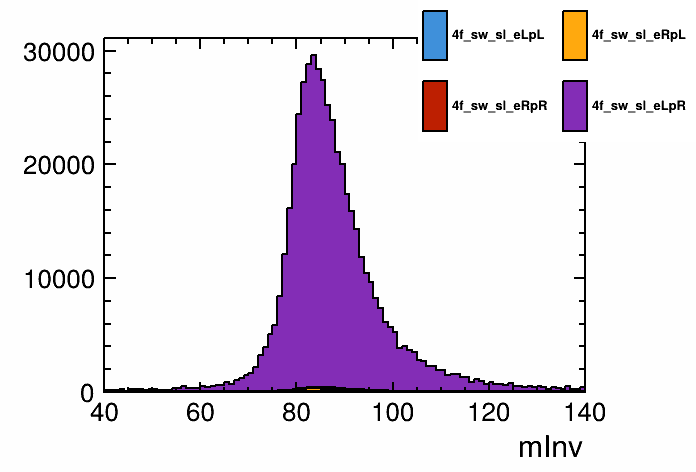

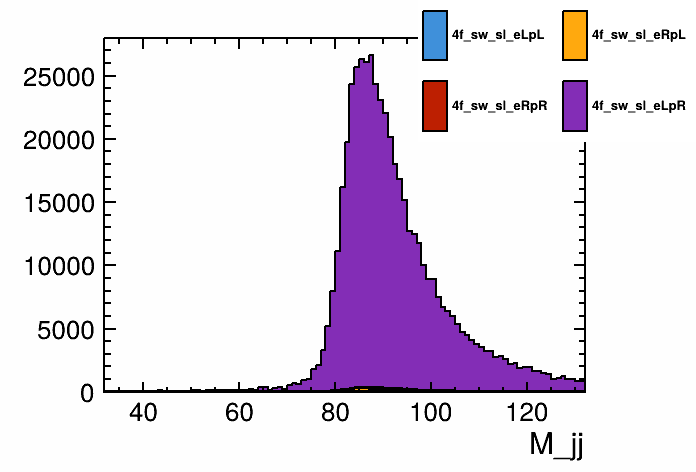

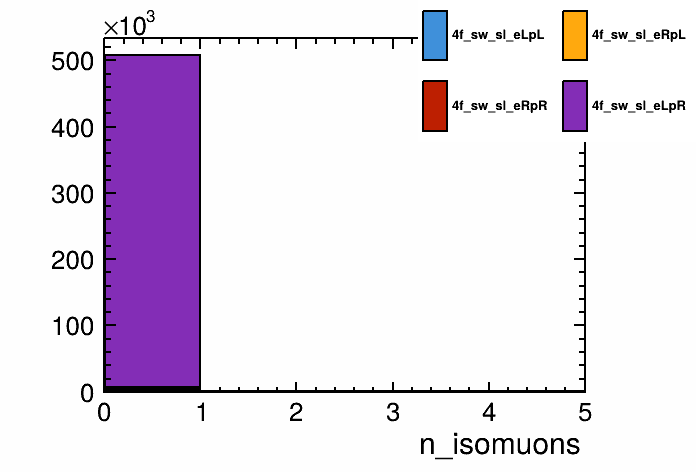

In [24]:
analysis.draw_histogram("PVertex_ndf")

analysis.draw_histogram("missE")
analysis.draw_histogram("mInv")
analysis.draw_histogram("M_jj")
analysis.draw_histogram("n_isomuons")

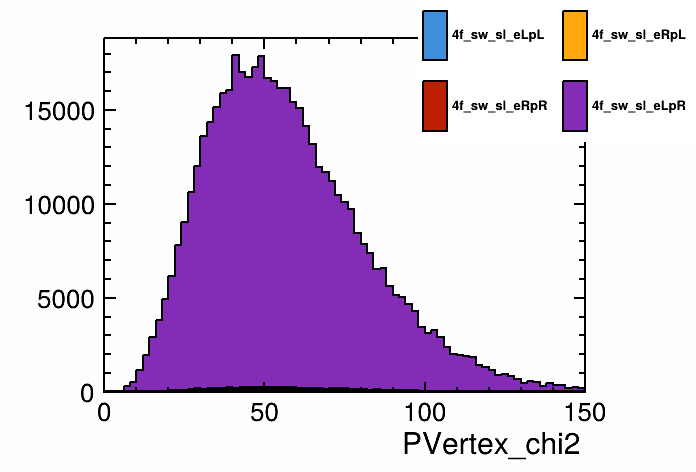

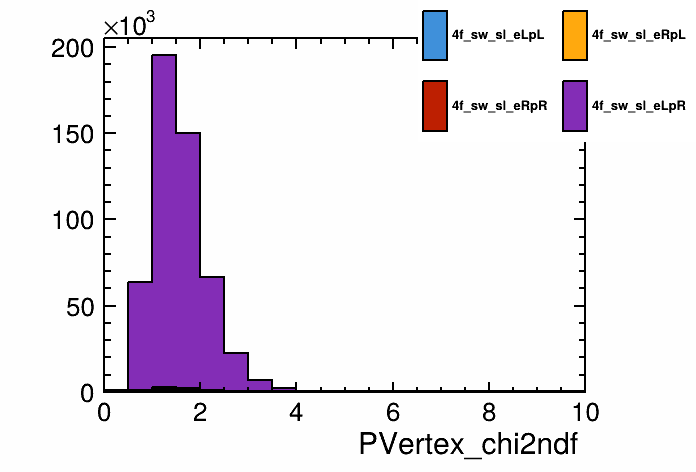

In [25]:
analysis.draw_histogram("PVertex_chi2")
analysis.draw_histogram("PVertex_chi2ndf")

In [26]:
# TODO: plot the 5 (10?) differential cross sections down here